# Analysis of Stroke Prediction Dataset

## Introduction
Exploratory data analysis (EDA) is a fundamental step in understanding a dataset before applying machine learning models. It helps identify missing values, outliers, and data inconsistencies while summarizing key characteristics of the dataset. In this notebook, variable distributions, relationships between features, and potential patterns that influence stroke in patients are analyzed. Additionally, visual exploration techniques provide deeper insights into feature interactions.
<br>
This notebook also contains target population definition, forming multiple statistical hypotheses and conducting statistical tests for these hypotheses.

### Goal
- Ensure data quality, explore trends, and extract meaningful insights that contribute to predictive modeling. 
- Test hypotheses to assess statistical significance and validate key assumptions about the dataset. 
- By performing analysis and statistical testing, optimize data preparation for machine learning models while uncovering important factors that increase stroke risk.

## Data
This dataset aims to predict the likelihood of a patient experiencing a stroke based on various input factors, including gender, age, pre-existing medical conditions, and smoking habits. Each row in the dataset contains relevant patient information to support this analysis.
### Inputs
1) *id*: unique identifier;
2) *gender*: "Male", "Female" or "Other";
3) *age*: age of the patient;
4) *hypertension*: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension;
5) *heart_disease*: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease;
6) *ever_married*: "No" or "Yes";
7) *work_type*: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed";
8) *Residence_type*: "Rural" or "Urban";
9) *avg_glucose_level*: average glucose level in blood;
10) *bmi*: body mass index;
11) *smoking_status*: "formerly smoked", "never smoked", "smokes" or "Unknown"*;
    - "Unknown" means that the information is unavailable for this patient.
### Output
- *stroke*: 1 if the patient had a stroke or 0 if not

### Data Leakage
- *avg_glucose_level*:
    - If it was recorded after a stroke event, ot may reflect a post-stroke condition rather than being a true predictor.
    - Were the values measured before the stroke occurred? If not, they should be removed or handled carefully.
        - There is no information on when these values were recorded. Prior assumption: these values were recorded some time before the stroke.
- *smoking_status*:
    - If the "Unknown" category correlates highly with stroke occurrences, it might indicate that data is missing not at random (MNAR), potentially leading to leakage.
    - Analyze whether "Unknown" is more common in stroke vs. non-stroke patients.
    - Analyze whether "Unknown" is more common in certain groups: young people due to privacy concerns or elderly patients who cannot provide a history.
- *hypertension* and *heart_disease:
    - While these are legitimate risk factors for strokes, it is important to confirm that the labels were recorded before the stroke event and not updated afterward.
        - There is no information on when these values were recorded. Prior assumption: these values were recorded some time before the stroke.

## Points for Discussion (Technical Aspects)
- How deep the EDA should be?
- Should newly created features be explored in same way?
    - Espetially statistical signifficance, relationship with the target.

# Imports and Configuration
The goal is to make sure that all the required libraries and packages are loaded, as well as notebook defaults are set at the beginning of the notebook, ensuring code has access to the necessary tools and functions.

In [1]:
import pandas as pd
import kagglehub
import os

from sklearn.model_selection import train_test_split

from utils.eda_utils import (
    check_missing_values,
    check_duplicates,
    find_outlier_rows_by_iqr,
)

from utils.vizualization_utils import (
    highlight_proportions,
    plot_target_col_ratio_ci_distribution,
    plot_qq_with_histogram,
    plot_histogram_with_hue,
    plot_category_counts,
)

from utils.stats_utils import (
    compute_vif,
    check_categorical_features_multicollinearity,
    test_categorical_variables,
    test_numerical_variables,
)

## Global Variables

In [2]:
ALPHA = 0.05

# Data Loading
The goal is to load all relevant data files into your notebook environment, making them accessible for analysis in subsequent cells.

In [3]:
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")
file_name = "healthcare-dataset-stroke-data.csv"
dataset_path = os.path.join(path, file_name)
print("Full path to the dataset file:", dataset_path)

Full path to the dataset file: /Users/agneskasablovskaja/.cache/kagglehub/datasets/fedesoriano/stroke-prediction-dataset/versions/1/healthcare-dataset-stroke-data.csv


In [4]:
stroke_df = pd.read_csv(filepath_or_buffer=dataset_path, sep=",")
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Dataset Overview
The goal is to understand data characteristics.

In [5]:
numerical_columns = stroke_df.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()
categorical_columns = stroke_df.select_dtypes(include="object").columns.tolist()
print("Dataset info:")
print(f"Entry count: {stroke_df.shape[0]}")
print(
    f"Data columns: {stroke_df.shape[1]}, out of which {len(numerical_columns)} numerical, and {len(categorical_columns)} categorical."
)

Dataset info:
Entry count: 5110
Data columns: 12, out of which 7 numerical, and 5 categorical.


In [6]:
print("Unique values per column and dara types:")
unique_counts = {col: stroke_df[col].nunique() for col in stroke_df.columns}
stroke_df_summary = pd.DataFrame.from_dict(
    unique_counts, orient="index", columns=["Unique Values"]
)
stroke_df_summary["Data Type"] = stroke_df.dtypes
stroke_df_summary

Unique values per column and dara types:


,Unique Values,Data Type
id,5110,int64
gender,3,object
age,104,float64
hypertension,2,int64
heart_disease,2,int64
ever_married,2,object
work_type,5,object
Residence_type,2,object
avg_glucose_level,3979,float64
bmi,418,float64


**Note on feature types:**
- Column id holds only unique values and will be used as and index. Such approach will also prevent unintentional signal usage.
- Columns that are  categorical are of object types.
- Feature types:
    - Categorical (Nominal): hypertension, heart_disease, gender, ever_married, work_type, Residence_type, smoking_status, stroke;
    - Continuos: avg_glucose_level, bmi, age.
    - The numeric features are already encoded correctly (`float` or `int`), but the categorical columns need some standartization and encoding.
<br>

In [7]:
stroke_df.set_index("id", inplace=True)

# Data Cleaning and Preprocessing
The goal is to prepare the raw data by handling issues such as missing values, data types, and outliers, ensuring that the dataset is ready for analysis or modeling.

## Inconsistent Data Entries
The goal of this section is to identify, analyze, and resolve inconsistencies within column names and categorical data to improve data quality and ensure uniformity.
<br>

**Note on fixing inconsistent categorical values:** all of the columns that have two unique values will be modified in a following manner:
- "Yes" values will be represented by 1, and "No" by 0.
    - This is a common convention. 
- Residence type column contains only 2 values that can be easily converted to "lives in urban area or not?" type of column.

In [8]:
stroke_df["ever_married"] = stroke_df["ever_married"].map({"Yes": 1, "No": 0})
stroke_df["Residence_type"] = stroke_df["Residence_type"].map({"Urban": 1, "Rural": 0})
stroke_df = stroke_df.rename(
    columns={
        "Residence_type": "urban_resident",
    }
)
stroke_df.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,urban_resident,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked,1


### Typos in Categorical Columns

In [9]:
categorical_columns = stroke_df.select_dtypes(include="object").columns.tolist()
print("Unique values in categorical columns:")
for categorical_col in categorical_columns:
    print(f"{categorical_col} col: {stroke_df[categorical_col].unique()}")

Unique values in categorical columns:
gender col: ['Male' 'Female' 'Other']
work_type col: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
smoking_status col: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


**Note on typos:**
- There seem to be no typos, but values could be more consistent.
- In work_type values 'children' and 'Never_worked' seem curious and require investigation.

In [10]:
vals_to_investigate = ["children", "Never_worked"]
for val in vals_to_investigate:
    min_age = stroke_df[stroke_df["work_type"] == val]["age"].min()
    max_age = stroke_df[stroke_df["work_type"] == val]["age"].max()
    print(f"{val} min age: {min_age}, max age: {max_age}")

children min age: 0.08, max age: 16.0
Never_worked min age: 13.0, max age: 23.0


In [11]:
stroke_df[stroke_df["work_type"] == "Never_worked"].sort_values(
    by="age", ascending=False
).head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,urban_resident,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
61408,Male,23.0,0,0,0,Never_worked,1,125.26,18.7,never smoked,0
13948,Female,19.0,0,0,0,Never_worked,1,86.96,25.8,never smoked,0
11702,Female,18.0,0,0,0,Never_worked,1,82.36,22.7,Unknown,0
13960,Female,18.0,0,0,0,Never_worked,1,97.65,21.5,Unknown,0
71966,Female,18.0,0,0,0,Never_worked,1,81.73,21.6,never smoked,0


**Note on work_type column inconsistencies:** 
- It seems that categories 'children' and 'Never_worked' mostly represent minors.
- There are two exceptions (19 and 23 years old), thus these values will simply be replaced with one category "unemployed".

In [12]:
stroke_df["work_type"] = stroke_df["work_type"].replace(
    {
        "Private": "private",
        "Self-employed": "self_employed",
        "Govt_job": "government",
        "children": "unemployed",
        "Never_worked": "unemployed",
    }
)
stroke_df["smoking_status"] = stroke_df["smoking_status"].replace(
    {
        "formerly smoked": "former_smoker",
        "never smoked": "never_smoked",
        "smokes": "smoker",
        "Unknown": "unknown",
    }
)
stroke_df["gender"] = stroke_df["gender"].astype(str).str.lower()

In [13]:
nominal_category_mappings = {
    "gender": {"male": 0, "female": 1, "other": 2},
    "work_type": {"private": 0, "self_employed": 1, "government": 2, "unemployed": 3},
    "smoking_status": {
        "former_smoker": 0,
        "never_smoked": 1,
        "smoker": 2,
        "unknown": 3,
    },
}

import json

with open("data/nominal_category_mappings.json", "w") as f:
    json.dump(nominal_category_mappings, f)

## Missing Values
The goal is to make sure that there are no missing or duplicate values, and if there are, impute it.
- Categorical columns were already investigated for unique values, if those columns contain missing values, it would have been seen already.

In [14]:
numerical_columns = stroke_df.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()
check_missing_values(df=stroke_df[numerical_columns])

Missing value counts by column:
age                    0
hypertension           0
heart_disease          0
ever_married           0
urban_resident         0
avg_glucose_level      0
bmi                  201
stroke                 0
dtype: int64


**Note on missing values:** BMI column contains quite many missung values.
- In order to understand the nature of it and handle it in most approriate way, this column will be closer investigated for patterns (or lack of it) in Distributions section.
- There are multiple reasons for bmi values to be missing:
    - Random occurence;
    - Systematic reasons related to:
        - Stroke patients;
        - Elderly or severe patients, etc.

## Duplicate Values
The goal is to make sure that there are no duplicate values, and if there are, handle it.

In [15]:
duplicate_rows = check_duplicates(df=stroke_df)
duplicate_rows

No duplicate rows found based on the columns: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'urban_resident', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


**Note on duplicates:** there are no duplicated rows based on all columns.
- Additional duplicate checkups will be performed: 
    - Excluding target variable, with the assumption that patient before and after stroke was added into the system;
    - Excluding BMI, variable with missing values, assuming that patient info was added twice with paritial info (no BMI) and full data.

In [16]:
no_bmi = [col for col in stroke_df.columns if "bmi" not in col]
duplicate_rows_no_bmi = check_duplicates(df=stroke_df[no_bmi])
duplicate_rows_no_bmi

No duplicate rows found based on the columns: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'urban_resident', 'avg_glucose_level', 'smoking_status', 'stroke']


In [17]:
no_stroke = [col for col in stroke_df.columns if "stroke" not in col]
duplicate_rows_no_stroke = check_duplicates(df=stroke_df[no_stroke])
duplicate_rows_no_stroke

No duplicate rows found based on the columns: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'urban_resident', 'avg_glucose_level', 'bmi', 'smoking_status']


# Exploratory Data Analysis
The goal is to explore the data’s characteristics and gain an initial understanding of patterns, distributions, and relationships within the dataset.

In [18]:
binary_columns = [
    col for col in numerical_columns if stroke_df[col].dropna().isin([0, 1]).all()
]
non_binary_numeric_columns = [
    col for col in numerical_columns if col not in binary_columns
]

print("Binary (0/1) columns:", binary_columns)
print("Non-binary numerical columns:", non_binary_numeric_columns)

Binary (0/1) columns: ['hypertension', 'heart_disease', 'ever_married', 'urban_resident', 'stroke']
Non-binary numerical columns: ['age', 'avg_glucose_level', 'bmi']


## Distribution of Numerical Input Features

In [19]:
print("Summary statistics (continuous numeric features):")
summary_stats_non_binary = stroke_df[non_binary_numeric_columns].describe()
summary_stats_non_binary

Summary statistics (continuous numeric features):


,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


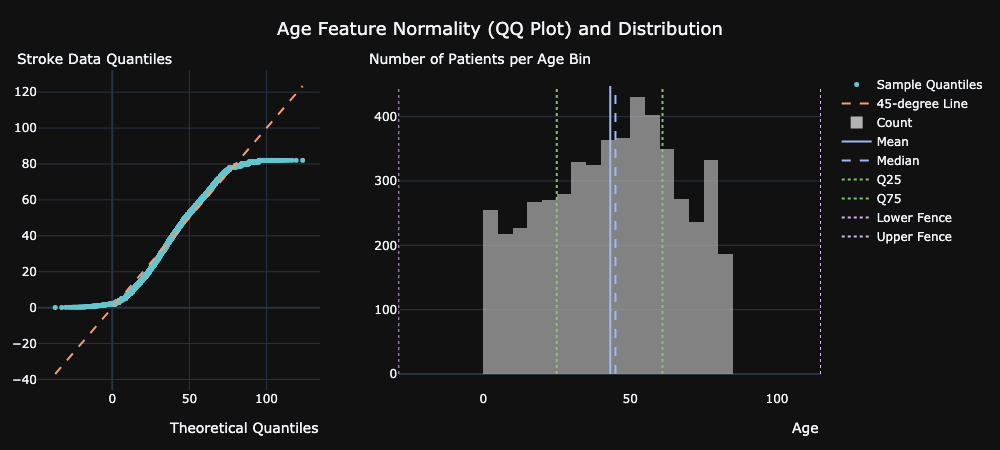

In [20]:
plot_qq_with_histogram(
    df=stroke_df,
    column="age",
    custom_title="Age Feature Normality (QQ Plot) and Distribution",
    custom_hist_y_label="Number of Patients per Age Bin",
    custom_qq_y_label="Stroke Data Quantiles",
    bins=20,
)

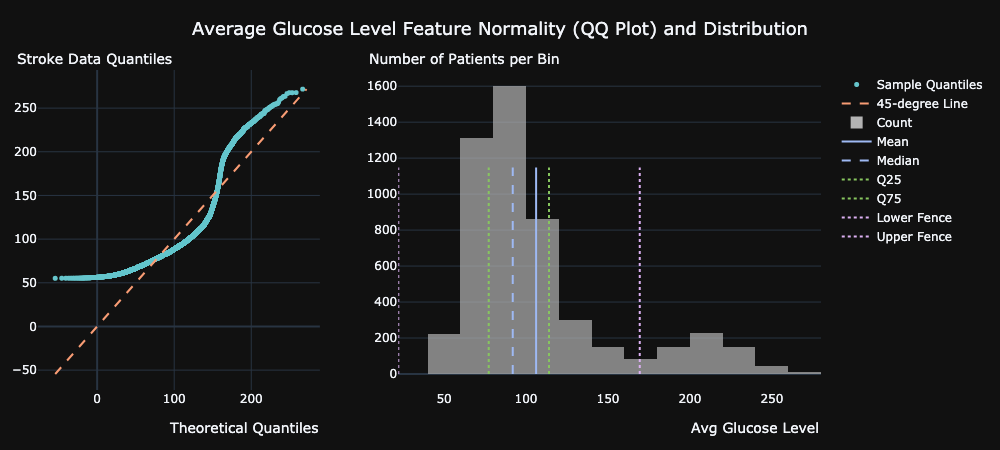

In [21]:
plot_qq_with_histogram(
    df=stroke_df,
    column="avg_glucose_level",
    custom_title="Average Glucose Level Feature Normality (QQ Plot) and Distribution",
    custom_hist_y_label="Number of Patients per Bin",
    custom_qq_y_label="Stroke Data Quantiles",
    bins=20,
)

In [22]:
stroke_count_total = stroke_df["stroke"].value_counts()[1]
stroke_count_glucose_outliers = find_outlier_rows_by_iqr(
    stroke_df, ["avg_glucose_level"]
)["stroke"].value_counts()[1]
print(
    f"{stroke_count_glucose_outliers/stroke_count_total*100:.2f}% of stroke cases appear as outliers in glucose column."
)

33.73% of stroke cases appear as outliers in glucose column.


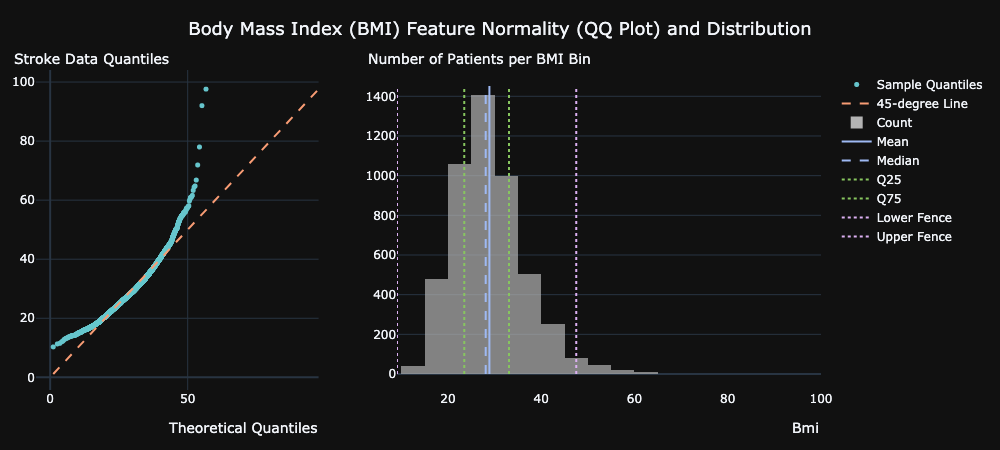

In [23]:
plot_qq_with_histogram(
    df=stroke_df,
    column="bmi",
    custom_title="Body Mass Index (BMI) Feature Normality (QQ Plot) and Distribution",
    custom_hist_y_label="Number of Patients per BMI Bin",
    custom_qq_y_label="Stroke Data Quantiles",
    bins=20,
)

In [24]:
stroke_count_bmi_outliers = find_outlier_rows_by_iqr(stroke_df, ["bmi"])[
    "stroke"
].value_counts()[1]
print(
    f"{stroke_count_bmi_outliers/stroke_count_total*100:.2f}% of stroke cases appear as outliers in bmi column."
)

0.80% of stroke cases appear as outliers in bmi column.


**Note on data distribution:** 
- BMI and Average Glucose Levels features are both skewed to the right, having some outliers there.
    - At least a third of stroke cases are in the outliers observations, filtering them out would substantially reduce label of interest observations.
    - Normal weight BMI is considered to be 20-25, patients in this data set are slightly overweight.
        - The highest BMI ever recorded belongs to Jon Brower Minnoch 186 (kg/m2), thus the BMI's outliers are possibly real observations.
    - Glucose levels depend on when they are measured, thus it's not possible to make some conslusion on whether people in the data set on average have higher or lower average glucose levels.
        - Registered outlier values are possibly real observations.
- There are no approximately normally distributed features.
    - If models, such as linear regression will be used, data normality will need to be addressed.

### Deeper Look into BMI Missing Values

In [25]:
missing_bmi = stroke_df[stroke_df["bmi"].isna()]
non_missing_bmi = stroke_df[stroke_df["bmi"].notna()]
comparison = pd.DataFrame(
    {
        "Missing BMI": round(missing_bmi[numerical_columns].mean(), 2),
        "Non-Missing BMI": round(non_missing_bmi[numerical_columns].mean(), 2),
    }
)
comparison

,Missing BMI,Non-Missing BMI
age,52.05,42.87
hypertension,0.23,0.09
heart_disease,0.16,0.05
ever_married,0.74,0.65
urban_resident,0.53,0.51
avg_glucose_level,126.72,105.31
bmi,NaN,28.89
stroke,0.20,0.04


**Note on systematically missing BMI:**
- Older individuals, stroke patients, and those with heart disease or hypertension are significantly more likely to have missing BMI.
- Higher glucose levels also correlate with missing BMI, which may indicate a health-related bias.

In [26]:
comparison_categorical = pd.DataFrame()
for col in categorical_columns:
    missing_proportions = round(missing_bmi[col].value_counts(normalize=True), 2)
    non_missing_proportions = round(
        non_missing_bmi[col].value_counts(normalize=True), 2
    )
    comparison_col = pd.DataFrame(
        {"Missing BMI": missing_proportions, "Non-Missing BMI": non_missing_proportions}
    )
    comparison_col["Category"] = comparison_col.index
    comparison_col["Feature"] = col
    comparison_categorical = pd.concat([comparison_categorical, comparison_col])

comparison_categorical.reset_index(drop=True, inplace=True)
comparison_categorical

,Missing BMI,Non-Missing BMI,Category,Feature
0,0.48,0.59,female,gender
1,0.52,0.41,male,gender
2,NaN,0.00,other,gender
3,0.13,0.13,government,work_type
4,0.57,0.57,private,work_type
5,0.22,0.16,self_employed,work_type
6,0.08,0.14,unemployed,work_type
7,0.24,0.17,former_smoker,smoking_status
8,0.20,0.38,never_smoked,smoking_status
9,0.26,0.15,smoker,smoking_status


**Note on systematically missing BMI:**
- Men are more likely to have missing BMI.
- Self-employed individuals & smokers have higher missing BMI.
- Never-smokers are less likely to have missing BMI.

**Final notes on handlingmissing BMI:**
- If missingness is systematic, simple imputation (mean/median) might introduce bias.
- Missing values seem to be systematic rathen than random;  
    - Regression model using age, hypertension, heart_disease, and smoking_status may be a better imputation strategy. 
    - But also, Tree based models, such as RandomForestClassifier, XGBoostClassifier, can handle missing values without additional care.
    - Leaving BMI missing during training can actually improve real-world usability, especially in healthcare scenarios where BMI is not always available. 

## The Number of Observations per Binary (Nominal) Features

In [27]:
binary_column_stats_dict = {}
total_entries = len(stroke_df)
binary_inputs = [col for col in binary_columns if col != "stroke"]
for col in binary_inputs:
    counts = stroke_df[col].value_counts()
    binary_column_stats_dict[col] = pd.DataFrame(
        {
            "feature": col,
            "value": counts.index,
            "answer": counts.index.map({0: "No", 1: "Yes"}),
            "counts": counts.values,
            "proportions": counts.values / total_entries,
        },
    ).set_index(["feature", "value"])
binary_column_stats = pd.concat(binary_column_stats_dict.values())
binary_column_stats["proportions"] = binary_column_stats["proportions"].apply(
    lambda x: round(x, 2)
)
binary_column_stats.sort_index(level=["feature", "value"], inplace=True)
print("General counts and proportions of nominal features (input and output):")
binary_column_stats.style.map(highlight_proportions, subset=["proportions"]).format(
    {"proportions": "{:.2f}"}
)

General counts and proportions of nominal features (input and output):


**Note on proportions of binary features:** 
- Input variables:
    - 71% of customers work in private sector or are self employed, 29% work in governmental sector;
    - Majority (85%) have graduated from the college;
    - Majority (72%) do not have chronic diseases;
    - Around 80% of customers are not considered frequent flyers, same proportion of people haven't been abroad.

## The Number of Observations per Nominal Features

### Work type

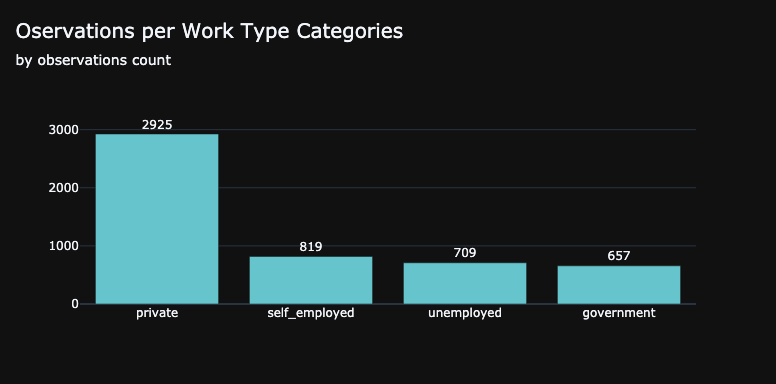

In [28]:
plot_category_counts(
    df=stroke_df,
    category_column="work_type",
    custom_title="Oservations per Work Type Categories",
    custom_subtitle="by observations count",
)

In [29]:
vals_to_investigate = stroke_df["work_type"].unique()
for val in vals_to_investigate:
    min_age = stroke_df[stroke_df["work_type"] == val]["age"].min()
    max_age = stroke_df[stroke_df["work_type"] == val]["age"].max()
    print(f"{val} min age: {min_age}, max age: {max_age}")

private min age: 8.0, max age: 82.0
self_employed min age: 7.0, max age: 82.0
government min age: 14.0, max age: 82.0
unemployed min age: 0.08, max age: 23.0


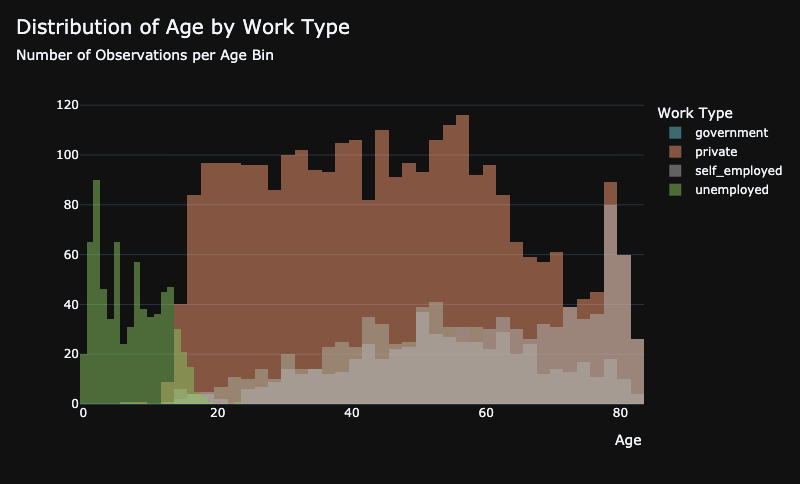

In [30]:
plot_histogram_with_hue(
    df=stroke_df,
    hue_column="work_type",
    target_metric_column="age",
    bins=40,
    custom_title="Distribution of Age by Work Type",
    custom_subtitle="Number of Observations per Age Bin",
)

**Note on work type feature:**
- Majority of people work in private sector, roughly accounting for 60% of observations;
- It seems a bit curious that there are minor people working in all three sectors.

### Gender

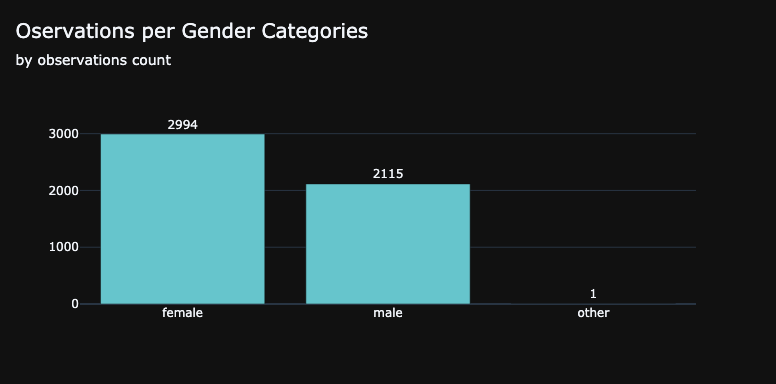

In [31]:
plot_category_counts(
    df=stroke_df,
    category_column="gender",
    custom_title="Oservations per Gender Categories",
    custom_subtitle="by observations count",
)

In [32]:
stroke_df[stroke_df["gender"] == "other"]

,gender,age,hypertension,heart_disease,ever_married,work_type,urban_resident,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
56156,other,26.0,0,0,0,private,0,143.33,22.4,former_smoker,0


**Note on gender distribution:**
- Around 60% of patiens in a dataset are women and 40% men;
- There is one observation of gender "other", non-stroke patient. This will be left for now.

### Smoking Status

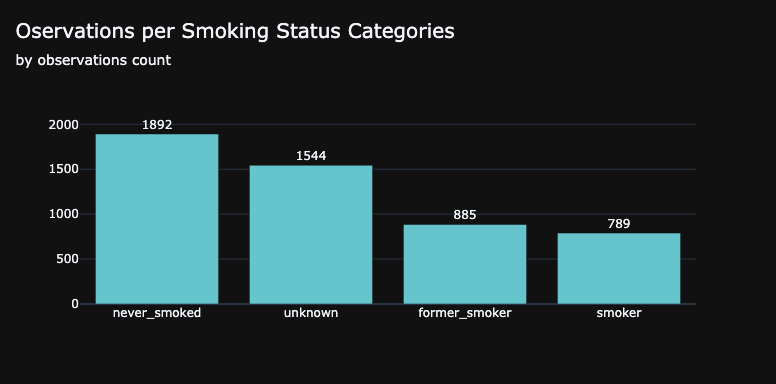

In [33]:
plot_category_counts(
    df=stroke_df,
    category_column="smoking_status",
    custom_title="Oservations per Smoking Status Categories",
    custom_subtitle="by observations count",
)

In [34]:
unknown_smoking_status = stroke_df[stroke_df["smoking_status"] == "unknown"]
known_smoking_status = stroke_df[stroke_df["smoking_status"] != "unknown"]
comparison_smoking_status = pd.DataFrame(
    {
        "Unknown Smoking Status": round(
            unknown_smoking_status[numerical_columns].mean(), 2
        ),
        "Known Smoking Status": round(
            known_smoking_status[numerical_columns].mean(), 2
        ),
    }
)
comparison_smoking_status

,Unknown Smoking Status,Known Smoking Status
age,30.23,48.85
hypertension,0.03,0.13
heart_disease,0.03,0.06
ever_married,0.42,0.76
urban_resident,0.51,0.51
avg_glucose_level,99.60,108.98
bmi,25.67,30.29
stroke,0.03,0.06


**Note on systematically recording Unknown smoking status:**
- Younger individuals (30.23 years) are much more likely to have "Unknown" smoking status than older individuals (48.85 years).
    - This suggests that smoking status might not have been recorded for younger patients, possibly because they haven't smoked yet or haven't been asked about smoking habits.
- Individuals with "Unknown" smoking status tend to have lower rates of hypertension, heart disease, and stroke.
    - This suggests that smoking status might be more frequently recorded for patients with pre-existing health conditions, as smoking is a risk factor.

In [35]:
comparison_categorical_smoking_status = pd.DataFrame()
for col in categorical_columns:
    unknown_smoking_status_proportions = round(
        unknown_smoking_status[col].value_counts(normalize=True), 2
    )
    known_smoking_status_proportions = round(
        known_smoking_status[col].value_counts(normalize=True), 2
    )
    comparison_col = pd.DataFrame(
        {
            "Unknown Smoking Status": unknown_smoking_status_proportions,
            "Known Smoking Status": known_smoking_status_proportions,
        }
    )
    comparison_col["Category"] = comparison_col.index
    comparison_col["Feature"] = col
    comparison_categorical_smoking_status = pd.concat(
        [comparison_categorical_smoking_status, comparison_col]
    )

comparison_categorical_smoking_status.reset_index(drop=True, inplace=True)
comparison_categorical_smoking_status[
    comparison_categorical_smoking_status["Feature"] != "smoking_status"
]

,Unknown Smoking Status,Known Smoking Status,Category,Feature
0,0.54,0.61,female,gender
1,0.46,0.39,male,gender
2,NaN,0.00,other,gender
3,0.08,0.15,government,work_type
4,0.41,0.64,private,work_type
5,0.10,0.19,self_employed,work_type
6,0.41,0.02,unemployed,work_type


**Note on systematically recording Unknown smoking status:**
- Unemployed individuals also more likely to have unknown smoking status, but this observation is closely related with age.
**Final notes:**
- "Unknown" category is not caused by the outcome (stroke), thus this is not a data leakage.
- Since "Unknown" is systematically assigned, keeping it as a separate category may preserve useful information.
- Works well for tree-based models (Random Forest, XGBoost, LightGBM).
- Other option that could be explored is to impute "unknown" using predictive model based on age and health conditions.

## Dataset's imbalance

In [36]:
target_column = "stroke"
stroke_df["stroke"].value_counts(normalize=True)

stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64

**Note on dataset's imbalace:**
- Dataset is highly imbalanced as the stroke cases account for only 4.87% of the data, while non-stroke cases make up 95.13%.
- Mitigation:
    - Stratified sampling for Train-Test split;
    - Tree-based models like RandomForest, XGBoost, and LightGBM support class_weight="balanced";
    - Use Precision-Recall AUC as an evaluation metric.

## Data Leakage
While features below are legitimate risk factors for strokes, it is important to confirm that the labels were recorded before the stroke event and not updated afterward. Data collection practices are not registered in Kaggle, but some logical testing can help to increase a believe in assumption that values were recorded prior stroke event.
- *heart_disease*:
    - If all stroke patients had heart_disease = 1, this would strongly suggest that the label was updated after the stroke event (i.e., data leakage).
- *hypertension*:
    - It is common for blood pressure to be elevated immediately after a stroke, even in patients who did not have a history of hypertension.
- *avg_glucose_level* and biometric measurements:
    - If they were recorded after a stroke event, they should be elevated.
- *smoking_status*:
    - Addressed in the Smoking Status section.



In [37]:
stroke_without_heart_disease = stroke_df[
    (stroke_df["stroke"] == 1) & (stroke_df["heart_disease"] == 0)
]
num_patients = stroke_without_heart_disease.shape[0]
total_stroke_patients = stroke_df[stroke_df["stroke"] == 1].shape[0]
print(
    f"Stroke patients without heart disease: {num_patients} out os {total_stroke_patients}."
)
if num_patients > 0:
    print(
        "There are stroke patients without heart disease. This suggests that heart disease was recorded before the stroke."
    )
else:
    print(
        "All stroke patients have heart disease. This suggests possible label leakage (recorded after stroke)."
    )

Stroke patients without heart disease: 202 out os 249.
There are stroke patients without heart disease. This suggests that heart disease was recorded before the stroke.


In [38]:
stroke_without_hypertension = stroke_df[
    (stroke_df["stroke"] == 1) & (stroke_df["hypertension"] == 0)
]
no_hypertention_rate = stroke_without_hypertension.shape[0] / total_stroke_patients
print(f"Stroke patients without hypertension: {no_hypertention_rate:.2%}.")
if no_hypertention_rate > 0.5:
    print(
        "Rate of stroke patients without hypertension is higher than with hypertension. This suggests that hypertension was recorded before the stroke."
    )
else:
    print(
        "Rate of stroke patients without hypertension is lower than with hypertension. This suggests possible label leakage (recorded after stroke)."
    )

Stroke patients without hypertension: 73.49%.
Rate of stroke patients without hypertension is higher than with hypertension. This suggests that hypertension was recorded before the stroke.


In [39]:
stroke_glucose_stats = stroke_df[stroke_df["stroke"] == 1][
    "avg_glucose_level"
].describe()
print(stroke_glucose_stats)
abs_range = stroke_glucose_stats["max"] - stroke_glucose_stats["min"]
print(f"\nAbsolute Range: {abs_range}")
if abs_range > 100:
    print(
        "The range of glucose levels for stroke patients is quite large. Suggesting this value was recorded before stroke."
    )
else:
    print(
        "The range of glucose levels for stroke patients is quite small. Suggesting this value was recorded after stroke."
    )

count    249.000000
mean     132.544739
std       61.921056
min       56.110000
25%       79.790000
50%      105.220000
75%      196.710000
max      271.740000
Name: avg_glucose_level, dtype: float64

Absolute Range: 215.63
The range of glucose levels for stroke patients is quite large. Suggesting this value was recorded before stroke.


**Note on data leakage:**
- Even though data collection information could profide definite answers on data leakage, but there is strong evidence that input features were recorded before the stroke, suggesting there is no data leakage.

## Target Population definition
- Includes both young and elderly individuals, mostly women and men, that are rural and urban residents.
- Some individuals are at higher stroke risk due to pre-existing health conditions, but also smoking. On average, people are slightly overweigth.
- These people have a recorded marriage status, work and residency types.

## Statistical Testing
The goal of defining hypotheses is to avoid bias deu to misleading interpretations, guide the analysis and make results more actionable (statistical significance testing).

### Hypotheses
#### Gender
-  H₀: Gender has no effect on the likelihood of having a stroke.
- H₁: Males are more likely to have a stroke than females.
    - Rationale: Some studies suggest that biological and lifestyle differences may contribute to higher stroke risks in men.

#### Age
- H₀: Age has no effect on the likelihood of having a stroke.
- H₁: Older individuals are more likely to have a stroke than younger individuals.
    - Rationale: Stroke risk generally increases with age due to factors like arterial changes, hypertension, and heart disease.

#### Hypertension
- H₀: Hypertension has no effect on the likelihood of having a stroke.
- H₁: Individuals with hypertension are more likely to have a stroke than those without hypertension.
    - Rationale: High blood pressure is a well-established risk factor for strokes.

#### Heart Disease
- H₀: Heart disease has no effect on the likelihood of having a stroke.
- H₁: Individuals with heart disease are more likely to have a stroke than those without heart disease.
    - Rationale: Heart conditions such as atrial fibrillation can increase the likelihood of clot formation, leading to strokes.

#### Ever Married
- H₀: Marital status has no effect on the likelihood of having a stroke.
- H₁: Married individuals are more likely to have a stroke than unmarried individuals.
    -  Rationale: Marriage may correlate with lifestyle factors such as stress, dietary habits, or social support that influence stroke risk.

#### Work Type
- H₀: Work type has no effect on the likelihood of having a stroke.
- H₁: Individuals in certain job types (e.g., self-employed, government jobs) are more likely to have a stroke.
    - Rationale: Different work types may be associated with different levels of stress, physical activity, and access to healthcare.

#### Residence Type
- H₀: Residence type has no effect on the likelihood of having a stroke.
- H₁: Urban residents are more likely to have a stroke than rural residents.
    - Rationale: Urban environments may expose individuals to higher levels of stress, pollution, and sedentary lifestyles.

#### Average Glucose Level
- H₀: Average glucose level has no effect on the likelihood of having a stroke.
- H₁: Individuals with higher average glucose levels are more likely to have a stroke.
    - Rationale: High glucose levels may indicate diabetes, which increases the risk of cardiovascular complications, including strokes.

#### BMI
- H₀: BMI has no effect on the likelihood of having a stroke.
- H₁: Individuals with higher or lower BMI than the normal range are more likely to have a stroke.
    - Rationale: Obesity and underweight conditions have been linked to different stroke risk factors, such as hypertension and malnutrition.

#### Smoking Status
- H₀: Smoking status has no effect on the likelihood of having a stroke.
- H₁: Current and former smokers are more likely to have a stroke than non-smokers.
    - Rationale: Smoking is a well-known risk factor for stroke due to its impact on blood vessels and clot formation.

**Note on test direction:** effect's direction is not always clear, thus two-tailed tests are performed, as it is more conservative approach and it informs whether there is a difference, which is enough for this specific application.

### Testing

In [40]:
categorical_results = test_categorical_variables(
    stroke_df, binary_inputs + categorical_columns, target_column, alpha=ALPHA
)
numerical_results = test_numerical_variables(
    stroke_df, non_binary_numeric_columns, target_column, alpha=ALPHA
)
final_results = pd.concat([categorical_results, numerical_results]).sort_values(
    by="conclusion", ascending=False
)
final_results

,feature,test,statistic,p-value,conclusion,warning: too little entries
0,hypertension,Chi-Square,81.605368,1.661622e-19,Significant,
1,heart_disease,Chi-Square,90.259561,2.088785e-21,Significant,
2,ever_married,Chi-Square,58.923890,1.638902e-14,Significant,
5,work_type,Chi-Square,10.265814,5.899387e-03,Significant,Excluded categories: {'unemployed'}
6,smoking_status,Chi-Square,29.147269,2.085400e-06,Significant,
0,age,Mann-Whitney U,200263.500000,3.726635e-71,Significant,
1,avg_glucose_level,Mann-Whitney U,471239.000000,3.640367e-09,Significant,
2,bmi,Mann-Whitney U,413278.500000,1.026429e-04,Significant,
3,urban_resident,Chi-Square,1.081637,2.983317e-01,Not Significant,
4,gender,Chi-Square,0.340003,5.598278e-01,Not Significant,Excluded categories: {'other'}


**Note on null hypotheses rejection:**
- Null hypothesis can be rejected for all but two features. Gender and living area (urban or rural) does not seem to have statistically significant impact on stroke risk.
- Excluded categories: catgories of the feature that have less than 5 entries per target label.
    - Gender 'other' in general has only one entry.
    - 'unemployed' category has only 2 entries with stroke.
- Even if a feature is not statistically significant in hypothesis testing, it may still improve model performance.

### Multicollinearity 
- Collinearity refers to the situation in which two or more predictor variables are closely related to one another.
- Some models are more sensitive to it than others:
    - Sensitive models: 
        - Linear Models (Linear, Polynomial, Regularized Linear);
        - Logistic Regression;
        - Support Vector Machines (SVM Linear & Kernel) somewhat sensitive, not as sensitive as models above.
    - Not sensitive models:
        - k-Nearest Neighbors (k-NN) and k-Means Clustering;
        - Decision Trees and Random Forest;

In [41]:
vif_results = compute_vif(
    stroke_df[numerical_columns], target_col=target_column, exclude_binary=False
)
vif_results

,variable,VIF,multicollinearity_interpretation
0,const,19.519968,High Multicollinearity (Consider Removing Feat...
1,age,2.141816,Low Multicollinearity
2,hypertension,1.108009,Low Multicollinearity
3,heart_disease,1.094173,Low Multicollinearity
4,ever_married,1.934683,Low Multicollinearity
5,urban_resident,1.000278,Low Multicollinearity
6,avg_glucose_level,1.097004,Low Multicollinearity
7,bmi,1.181113,Low Multicollinearity


**Note on multicollinearity:** input features are not showing signs of multicollinearity.
- VIF method technically works on binary features, but results can be misleading, thus additional testing will be applied.

In [42]:
binary_collinearity_results = check_categorical_features_multicollinearity(
    df=stroke_df,
    categorical_cols=binary_inputs + categorical_columns,
    significance_level=ALPHA,
)
significant_collinearity_df = binary_collinearity_results[
    binary_collinearity_results["dependent"] == "Yes"
]
significant_collinearity_df

,feature1,feature2,chi-Square,p-value,dependent
13,ever_married,work_type,1644.109329,0.000000e+00,Yes
20,work_type,smoking_status,1350.886270,3.154591e-285,Yes
14,ever_married,smoking_status,599.046474,1.622200e-129,Yes
1,hypertension,ever_married,136.682855,1.414676e-31,Yes
4,hypertension,work_type,135.199672,4.096090e-29,Yes
5,hypertension,smoking_status,103.874201,2.282023e-22,Yes
6,heart_disease,ever_married,66.098525,4.289366e-16,Yes
9,heart_disease,work_type,70.701626,3.020015e-15,Yes
0,hypertension,heart_disease,58.336664,2.208890e-14,Yes
19,gender,smoking_status,57.338347,1.560307e-10,Yes


In [43]:
feature1_counts = significant_collinearity_df["feature1"].value_counts()
feature2_counts = significant_collinearity_df["feature2"].value_counts()
feature_counts = feature1_counts.add(feature2_counts, fill_value=0).astype(int)
feature_counts_df = feature_counts.reset_index()
feature_counts_df.columns = ["Feature", "Count"]
feature_counts_df = feature_counts_df.sort_values(by="Count", ascending=False)
feature_counts_df

,Feature,Count
0,ever_married,5
2,heart_disease,5
4,smoking_status,5
5,work_type,5
1,gender,4
3,hypertension,4


**Note on multicollinearity among binary features:**
- Some feature pairs exhibit multicollinearity, and close attention will need to be paid when using sensitive models (if used).
    - 7 out of 6 features are collinear to other 4-5 features.
- Tree models generally are not sensitive to this, but multicollinearity can affect feature importance interpretations.

## Associations Among the Predictor Variables and Response Variable
The goal is to determine the relationship type and strength of the variables, in order to decide which features to use in a model, whether and what transformations are needed.

### Gender
Statistically unsignificant.

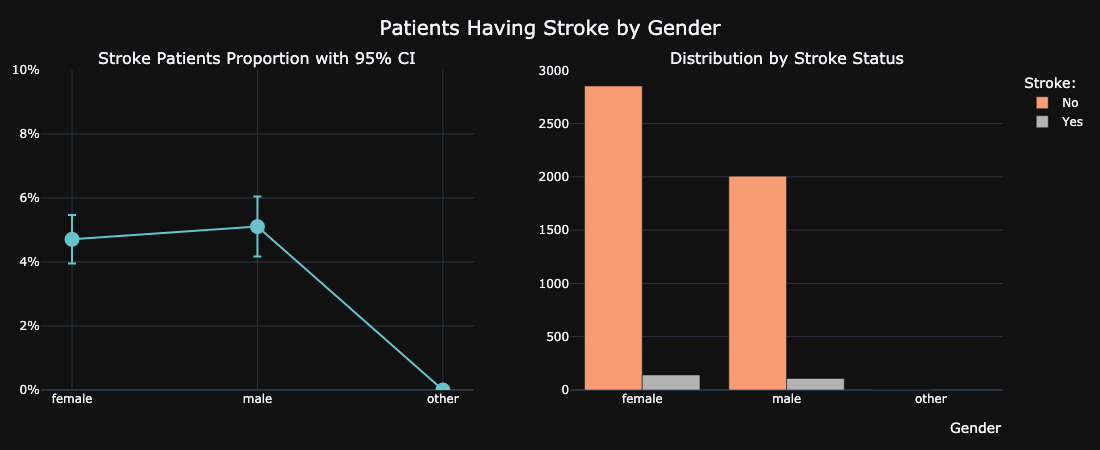

In [44]:
plot_target_col_ratio_ci_distribution(
    df=stroke_df,
    input_col="gender",
    target_col=target_column,
    y_threshold=0.1,
    custom_title="Patients Having Stroke by Gender",
    scatter_title="Stroke Patients Proportion with 95% CI",
    secondary_chart_title="Distribution by Stroke Status",
    custom_x_axis_title="Gender",
)

**Note on gender effect on stroke risk:**
- There is no significant difference in having a stroke ratio depending on gender (female or male).
    - Around 5% of patient in each of the gender groups had a stroke.

### Age

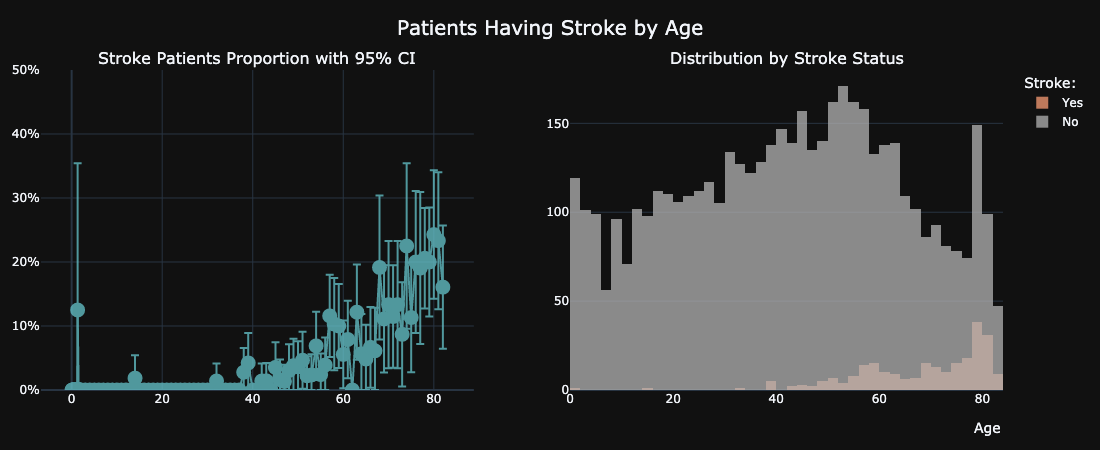

In [45]:
plot_target_col_ratio_ci_distribution(
    df=stroke_df,
    input_col="age",
    target_col=target_column,
    y_threshold=0.5,
    custom_title="Patients Having Stroke by Age",
    scatter_title="Stroke Patients Proportion with 95% CI",
    secondary_chart_title="Distribution by Stroke Status",
    custom_x_axis_title="Age",
)

**Note on age effect on stroke risk:**
- Starting with 40 years old, stroke risk keeps increasing.

### Hypertension

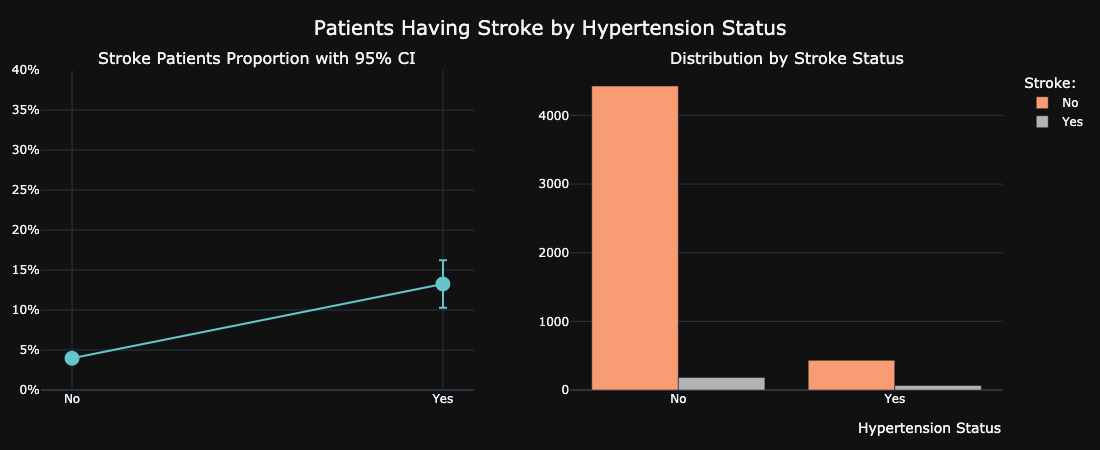

In [46]:
plot_target_col_ratio_ci_distribution(
    df=stroke_df,
    input_col="hypertension",
    target_col=target_column,
    y_threshold=0.4,
    custom_title="Patients Having Stroke by Hypertension Status",
    scatter_title="Stroke Patients Proportion with 95% CI",
    secondary_chart_title="Distribution by Stroke Status",
    custom_x_axis_title="Hypertension Status",
)

**Note on hypertension effect on stroke risk:**
- The rate of people having stroke is 3 times higher for patients with hypertension.

### Heart Disease

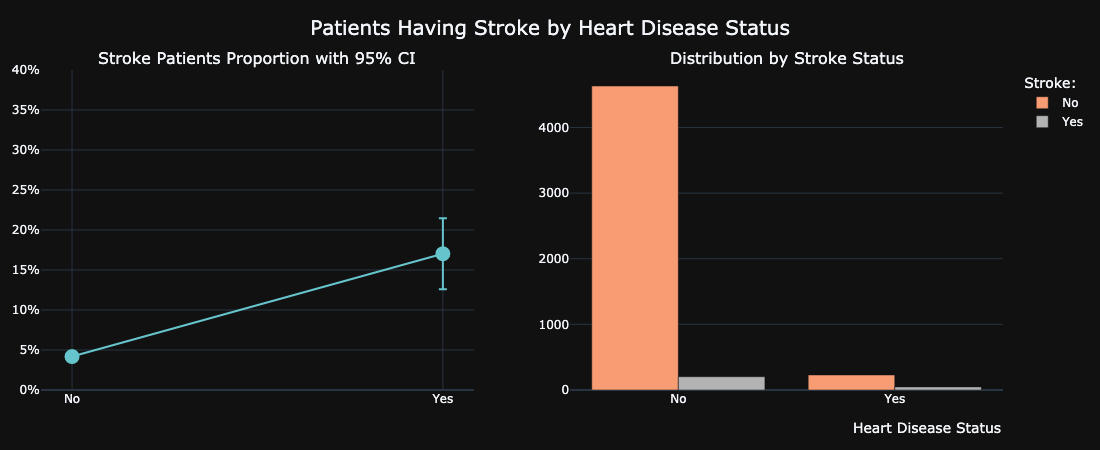

In [47]:
plot_target_col_ratio_ci_distribution(
    df=stroke_df,
    input_col="heart_disease",
    target_col=target_column,
    y_threshold=0.4,
    custom_title="Patients Having Stroke by Heart Disease Status",
    scatter_title="Stroke Patients Proportion with 95% CI",
    secondary_chart_title="Distribution by Stroke Status",
    custom_x_axis_title="Heart Disease Status",
)

**Note on heart disease effect on stroke risk:**
- The rate of people having stroke is 4 times higher for patients with heart disease.

### Ever Married

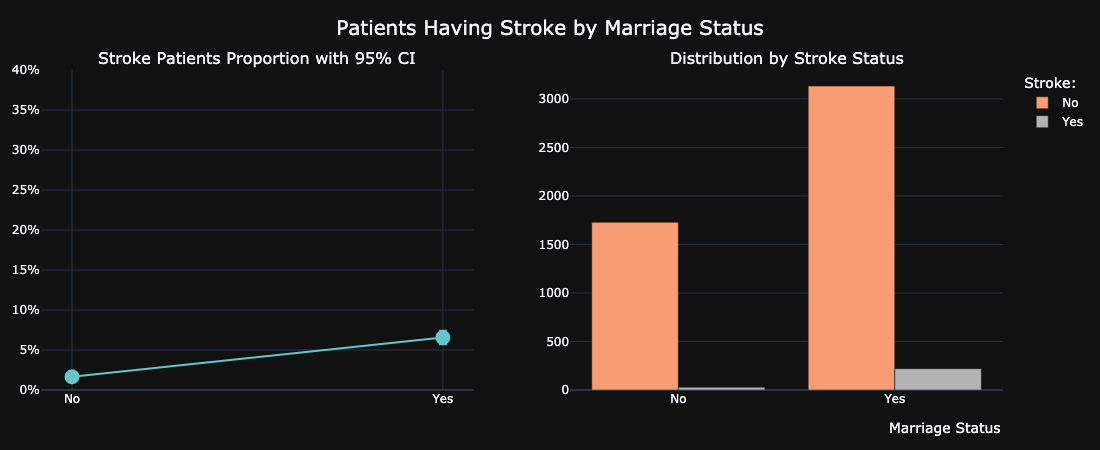

In [48]:
plot_target_col_ratio_ci_distribution(
    df=stroke_df,
    input_col="ever_married",
    target_col=target_column,
    y_threshold=0.4,
    custom_title="Patients Having Stroke by Marriage Status",
    scatter_title="Stroke Patients Proportion with 95% CI",
    secondary_chart_title="Distribution by Stroke Status",
    custom_x_axis_title="Marriage Status",
)

In [49]:
stroke_df.groupby("ever_married")["age"].describe()

,count,mean,std,min,25%,50%,75%,max
ever_married,,,,,,,,
0,1757.0,22.014229,18.474467,0.08,9.0,18.0,28.0,82.0
1,3353.0,54.342082,15.527678,18.00,42.0,54.0,66.0,82.0


**Note on marriage effect on stroke risk:**
- The rate of people having stroke is 3 times higher for ever married patients.
    - Age is most likely the main reason for the higher stroke rate among married individuals. Ever married patients are significantly older suggesting that age, not marital status itself, is the main driver of stroke risk.

### Work Type

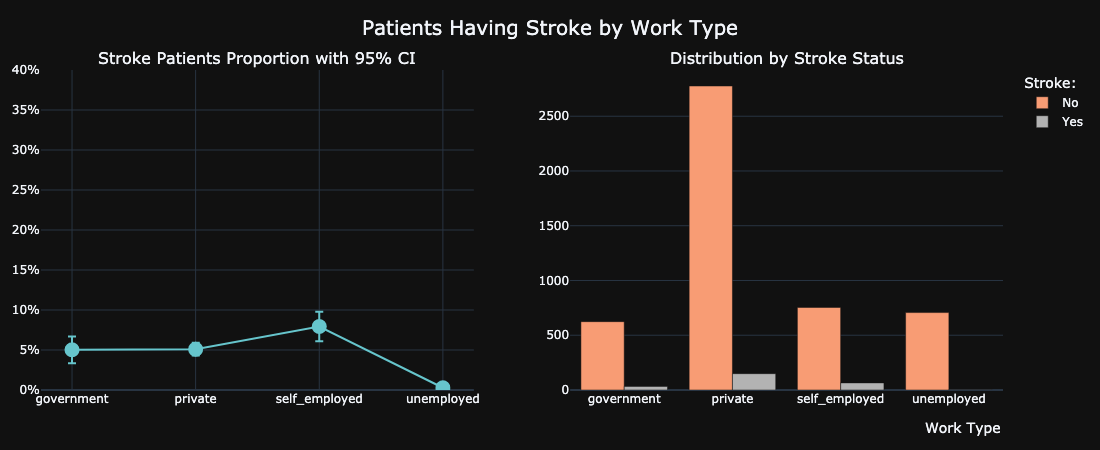

In [50]:
plot_target_col_ratio_ci_distribution(
    df=stroke_df,
    input_col="work_type",
    target_col=target_column,
    y_threshold=0.4,
    custom_title="Patients Having Stroke by Work Type",
    scatter_title="Stroke Patients Proportion with 95% CI",
    secondary_chart_title="Distribution by Stroke Status",
    custom_x_axis_title="Work Type",
)

In [51]:
stroke_df[(stroke_df["work_type"] == "unemployed") & (stroke_df["stroke"] == 1)]

,gender,age,hypertension,heart_disease,ever_married,work_type,urban_resident,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
69768,female,1.32,0,0,0,unemployed,1,70.37,NaN,unknown,1
49669,female,14.00,0,0,0,unemployed,0,57.93,30.9,unknown,1


**Note on work type effect on stroke risk:**
- Self-employed people are most likely to get a stroke, while unemployed least. This is closely related to the fact that unemployed people are minors.
- 2 cases of minors having a stroke:
    - Female 14 is slightly obese and no other risk factors;
    - Baby have no risk factors, unless a bmi that is not recorded.

### Residence Type
Statistically unsignificant.

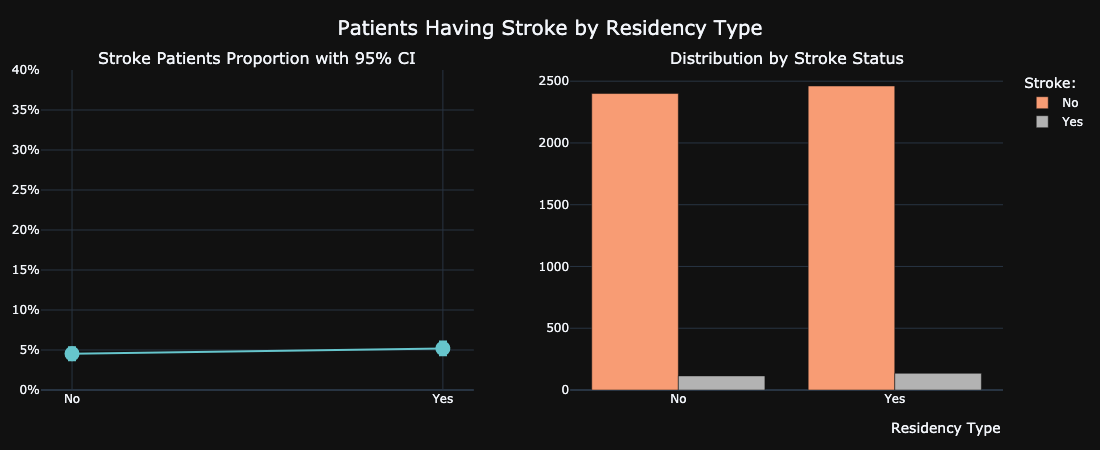

In [52]:
plot_target_col_ratio_ci_distribution(
    df=stroke_df,
    input_col="urban_resident",
    target_col=target_column,
    y_threshold=0.4,
    custom_title="Patients Having Stroke by Residency Type",
    scatter_title="Stroke Patients Proportion with 95% CI",
    secondary_chart_title="Distribution by Stroke Status",
    custom_x_axis_title="Residency Type",
)

**Note on residency type effect on stroke risk:**
- There is no significant difference in having a stroke ratio depending on residency type.
    - Around 5% of patient in each of the recidency type groups had a stroke.

### Average Glucose Level
Binning is used only for the visualization purposes.

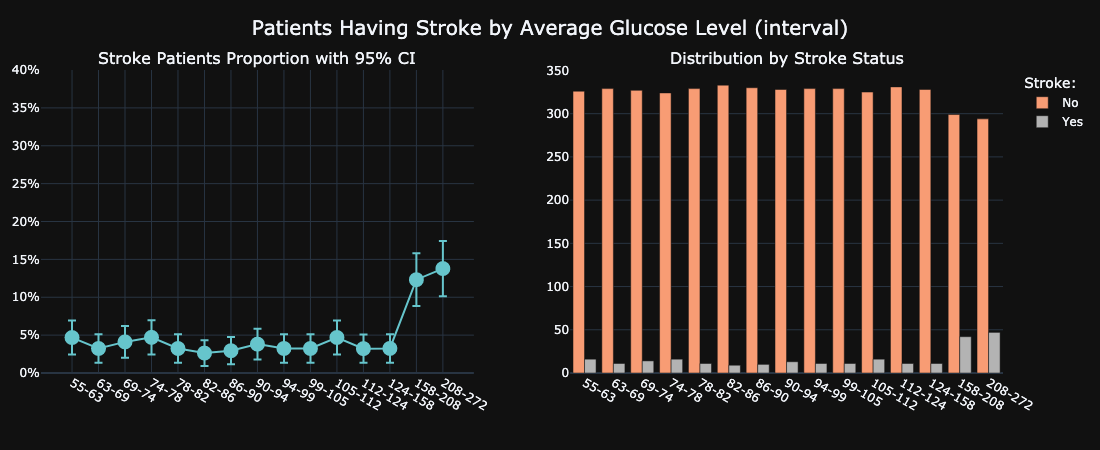

In [53]:
bin_count = 15
glucose_bins = pd.qcut(stroke_df["avg_glucose_level"], q=bin_count, duplicates="drop")
bin_ranges = pd.qcut(stroke_df["avg_glucose_level"], q=bin_count, duplicates="drop")
glucose_group_labels = [
    f"{round(interval.left,)}-{round(interval.right,)}"
    for interval in bin_ranges.cat.categories
]
stroke_df["avg_glucose_level_group"] = glucose_bins.cat.rename_categories(
    glucose_group_labels
)
plot_target_col_ratio_ci_distribution(
    df=stroke_df,
    input_col="avg_glucose_level_group",
    target_col=target_column,
    y_threshold=0.4,
    custom_title="Patients Having Stroke by Average Glucose Level (interval)",
    scatter_title="Stroke Patients Proportion with 95% CI",
    secondary_chart_title="Distribution by Stroke Status",
    custom_x_axis_title="",
)
stroke_df.drop(columns=["avg_glucose_level_group"], inplace=True)

**Note on glucose levels effect on stroke risk:**
- Patients with very high glucose levels (above 158) have higher risk of stroke.

### BMI
Binning is used only for the visualization purposes.

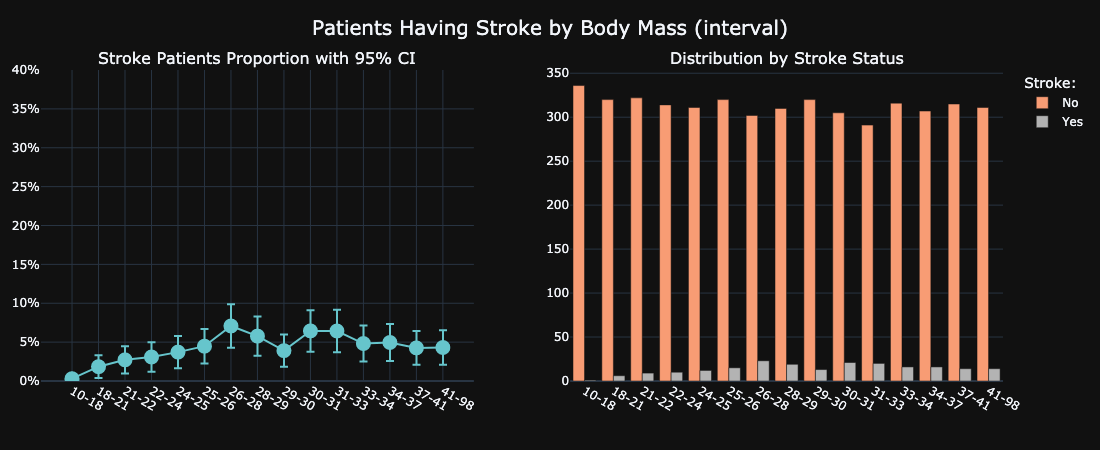

In [54]:
bin_count = 15
bmi_bins = pd.qcut(stroke_df["bmi"], q=bin_count, duplicates="drop")
bin_ranges = pd.qcut(stroke_df["bmi"], q=bin_count, duplicates="drop")
bmi_group_labels = [
    f"{round(interval.left,)}-{round(interval.right,)}"
    for interval in bin_ranges.cat.categories
]
stroke_df["bmi_group"] = bmi_bins.cat.rename_categories(bmi_group_labels)
plot_target_col_ratio_ci_distribution(
    df=stroke_df,
    input_col="bmi_group",
    target_col=target_column,
    y_threshold=0.4,
    custom_title="Patients Having Stroke by Body Mass (interval)",
    scatter_title="Stroke Patients Proportion with 95% CI",
    secondary_chart_title="Distribution by Stroke Status",
    custom_x_axis_title="",
)
stroke_df.drop(columns=["bmi_group"], inplace=True)

**Note on BMI effect on stroke risk:**
- Rates of patiens with strokes are increasing with the increasing BMI up until is reached the BMI that is considered slightly obese (over 25).

### Smoking Status

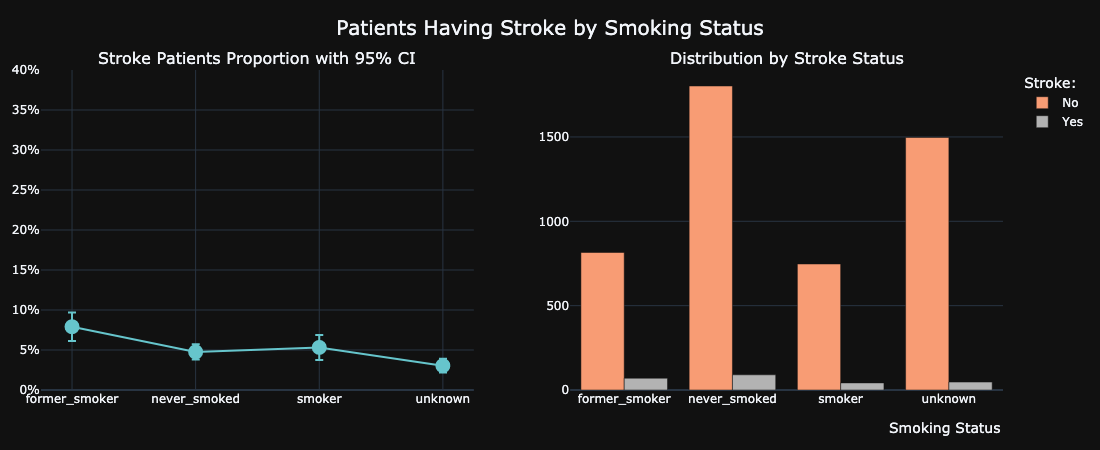

In [55]:
plot_target_col_ratio_ci_distribution(
    df=stroke_df,
    input_col="smoking_status",
    target_col=target_column,
    y_threshold=0.4,
    custom_title="Patients Having Stroke by Smoking Status",
    scatter_title="Stroke Patients Proportion with 95% CI",
    secondary_chart_title="Distribution by Stroke Status",
    custom_x_axis_title="Smoking Status",
)

In [56]:
stroke_df.groupby("smoking_status")["age"].describe()

,count,mean,std,min,25%,50%,75%,max
smoking_status,,,,,,,,
former_smoker,885.0,54.929944,17.641723,10.00,43.0,57.0,69.0,82.0
never_smoked,1892.0,46.744715,19.769584,10.00,31.0,47.0,62.0,82.0
smoker,789.0,47.096324,16.413002,10.00,33.0,47.0,59.0,82.0
unknown,1544.0,30.229922,25.055556,0.08,8.0,23.0,51.0,82.0


**Note on smoking effect on stroke risk:**
- Former smokers have highest risk of stroke, though such finding seems to be related with the fact that former smokers are also the oldest group.

# Data Partionionig
Data preprocessing operations (such as imputation, target encoding, feature selecetion based on mutual information of entire data set, etc.) applied before splitting the data might cause data leakage. 
- Two data set approach (80% / 20% for training / testing) will be used due to small data set size.

In [57]:
train_df, test_df = train_test_split(
    stroke_df, test_size=0.2, random_state=42, stratify=stroke_df[target_column]
)
train_df.to_csv("data/train.csv", index=False)
test_df.to_csv("data/test.csv", index=False)

# Closing Remarks for the EDA
- Tree models will be explored for the classification task.

- Dataset of 5110 rows was split into training and testing data (20%). 
    - No data was filtered out yet. There are not duplicated entries.
    - id is used as an index, preserving ordiginal information and preventing a model learning misleading patterns;
    - All of the original features, except id, will be used in further step (feature engineering).
-  Major data cleaning step done:
    - Column residence_type, holding two values ('urban' and 'rural') was converted into a binary column urban_resident.

- BMI has some missing values:
    - These seem to be systematic and are not fixed as tree models can handle and leaving missing values can improve real-world usability.
- Smoking status feature contains value 'unknown', which also seems to be systematic and it left unchanged to preserve potentially useful information.

- Outliers and data normality: numerical features bmi and average glucose level contains outliers on a higher end of range.
   - Tree models do no require for data to be normal, thus transformations to fix this are not required.
   - Outliers are not removed in this stage, but
        - Tree models might overfit (setting max_depth, min_samples_split could help);
        - But removing outliers would result in big loss of stroke cases (third of it) further increasing dataset's imbalance.
        - New feature wll be created to separate average glucose outliers. 

- Dataset is highly imbalanced.
    - Stroke cases account for only 4.87% of the data, while non-stroke cases make up 95.13%.

- Most likely there is no data leakage retalted to recording important information, such as heart disease, after stroke happens.
    - All input features will be used in further steps.